In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../")

In [3]:
import pickle
from itertools import chain
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [4]:
import textgen

## Load data

In [5]:
comments_path = textgen.get_resource_path("toxicity-data-merged-comments-05251530.csv")
comments = pd.read_csv(comments_path, index_col=0)
posts_path = textgen.get_resource_path("toxicity-data-merged-posts-05251530.csv")
posts = pd.read_csv(posts_path, index_col=0)

In [6]:
def load_pretrained_wv(fpath):
    with open(fpath, "rb") as fin:
        (itos, stoi, vectors) = pickle.load(fin)
        src_vocab = textgen.Vocabulary(itos, stoi, vectors)
    return src_vocab
posts_vocab = load_pretrained_wv(textgen.get_resource_path("word_vectors.pkl"))

In [7]:
chunks = [x for x in chain.from_iterable([x.split("\\") for x in comments.CommentContent.tolist()])]

In [8]:
comments_vocab = textgen.Vocabulary()
comments_vocab.build_vocabulary(chunks)

In [10]:
vocab_path = textgen.get_data_path("vocab.pkl")
with open(vocab_path, "wb") as fout:
    pickle.dump((posts_vocab, comments_vocab), fout)
posts_vocab, comments_vocab

(<Vocabulary: 27074 items, emb dim: (27074, 300)>, <Vocabulary: 1468 items>)

In [11]:
toxic_data = textgen.ToxicDataset(posts, comments, posts_vocab, comments_vocab)
toxic_data_path = textgen.get_data_path("toxic_data.pkl")
toxic_data.save(toxic_data_path)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\seantyh\AppData\Local\Temp\jieba.cache
Loading model cost 0.652 seconds.
Prefix dict has been built succesfully.


Cannot find gayo01
Cannot find gayo01
Cannot find gayo01


In [12]:
toxic_data_path = textgen.get_data_path("toxic_data.pkl")
toxic_data = textgen.ToxicDataset.load(toxic_data_path)
toxic_data

<ToxicDataset: 240 samples>

## Batching Data

In [19]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

In [20]:
from torch.utils.data import DataLoader
from functools import partial
collate_fn = partial(textgen.collate_fn, 
                     src_pad=posts_vocab.stoi["<PAD>"], 
                     tgt_pad=comments_vocab.stoi["<PAD>"])

In [21]:
xx, yy = next(iter(DataLoader(toxic_data, batch_size=2, collate_fn=collate_fn)))

In [22]:
USE_CUDA = True
if torch.cuda.is_available() and USE_CUDA:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [23]:
loss_fn = nn.CrossEntropyLoss()
model = textgen.ToxicCommentModel(posts_vocab, comments_vocab, device)
model = model.to(device)
adam = optim.Adam(model.parameters(), lr=1e-2)
loss_vec = []
acc_vec = []

In [31]:
from itertools import islice
n_epoch = 300
model.train()
for epoch_i in tqdm(range(n_epoch)):
    acc_epoch = []
    loss_epoch = []
    loader = DataLoader(toxic_data, batch_size=30, 
                        collate_fn=collate_fn)
    for src_batch, tgt_batch in loader:      
        src_batch = src_batch.to(device)
        tgt_batch = tgt_batch.to(device)
        out = model(src_batch, tgt_batch)
        loss = loss_fn(out.permute(1,2,0), tgt_batch.permute(1, 0))    
        loss_epoch.append(loss.item())
        
        out_seq = out.argmax(2).detach().cpu().numpy()
        tgt_seq = tgt_batch.detach().cpu().numpy()
        acc_seq = [textgen.get_seq_overlap(out_seq[i], tgt_seq[i], comments_vocab) 
                   for i in range(len(tgt_seq))]
        acc = np.mean(acc_seq)
        acc_epoch.append(acc)
        
        adam.zero_grad()
        loss.backward()
        adam.step()
    loss_vec.append(np.sum(loss_epoch))
    acc_vec.append(np.mean(acc_epoch))
    

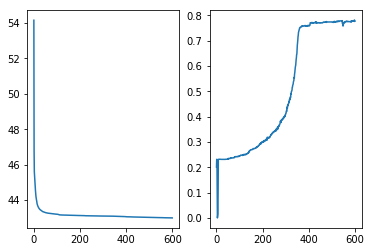

In [32]:
fig, axes = plt.subplots(1,2)
axes[0].plot(loss_vec)
axes[1].plot(acc_vec)

In [33]:
model_path = textgen.get_data_path("toxic-model-max-30-200.pt")

torch.save(model.state_dict(), model_path)

In [125]:
model.eval()
cpu_model = model.to(torch.device('cpu'))
xx = torch.LongTensor(textgen.convert_text("今天是星期三", posts_vocab))
out = cpu_model(xx, yy)
out = out.cpu().argmax(2).numpy()
textgen.inverse_convert_comment(out[0], comments_vocab)
# comments_vocab.stoi["<EOS>"]
# comments_vocab.itos[1464]

['【冥主奧步洞】',
 '不然',
 '繼續貸款金主',
 '難到要拿 芭樂 護台灣？',
 '難到要拿 芭樂 護台灣？',
 '何止與惡零距離，',
 '【冥主奧步洞】',
 '那收錢收到手軟',
 '那收錢收到手軟',
 '好幾年前的文章',
 '好幾年前的文章',
 '好幾年前的文章']